solafune:夜間光コンペ Baseline(xgb,lgb,cat)(by tubo)

https://qiita.com/tubo/items/f83a97f2488cc1f40088 の写経

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
#from ptitprince import RainCloud

from pandas_profiling import ProfileReport
%matplotlib inline

print(os.getcwd())

/content


In [3]:
INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/inputs/'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/outputs/'
NB_NAME = 'nb004'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'TrainDataSet.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'EvaluationData.csv'))

In [4]:
train_df.shape

(21883, 5)

In [5]:
target = train_df['AverageLandPrice']

In [6]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()

In [7]:
class LagBlock(BaseBlock):
    def __init__(self, lag:int, cols):
        self.lag = lag
        self.cols = cols
        
    def transform(self, input_df):
        # Yearはちゃんと時系列順になってるか全部は見てない
        output_df = input_df.groupby('PlaceID')[self.cols].diff(self.lag)
        return output_df.add_prefix(f'Lag_{self.lag}')

In [8]:
lb = LagBlock(1, ['MeanLight', 'SumLight'])
lb.transform(train_df)

,Lag_1MeanLight,Lag_1SumLight
0,NaN,NaN
1,5.142857,36.0
2,-0.857144,-6.0
3,-0.142856,-1.0
4,1.142856,8.0
...,...,...
21878,-0.661726,-4.0
21879,5.755319,541.0
21880,-4.138298,-389.0
21881,1.179536,42.0


In [9]:
train_df.groupby('PlaceID')['MeanLight'].diff(1).reset_index()

,index,MeanLight
0,0,NaN
1,1,5.142857
2,2,-0.857144
3,3,-0.142856
4,4,1.142856
...,...,...
21878,21878,-0.661726
21879,21879,5.755319
21880,21880,-4.138298
21881,21881,1.179536


In [10]:
train_df.groupby('PlaceID')['MeanLight'].diff(1).shape

(21883,)

In [11]:
# key毎の集約特徴量
class GroupBlock(BaseBlock):
    def __init__(self, key:str, function:str, target_col:list):
        self.key = key
        self.function = function
        self.meta_df = None
        self.target_col = target_col
        
    def transform(self, input_df):
        _df = input_df[self.target_col].groupby(input_df[self.key])
        # ここagg()のほうがわかりやすくね
        agg = getattr(type(_df), self.function)
        _df = agg(_df)
        self.meta_df = _df
        
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'GE{self.function}_{self.key}_')
        return out_df
        

In [12]:
lb = GroupBlock('PlaceID', 'max', ['MeanLight', 'SumLight'])
lb.fit(train_df)

,GEmax_PlaceID_MeanLight,GEmax_PlaceID_SumLight
0,62.857143,440.0
1,62.857143,440.0
2,62.857143,440.0
3,62.857143,440.0
4,62.857143,440.0
...,...,...
21878,16.734043,1573.0
21879,16.734043,1573.0
21880,16.734043,1573.0
21881,16.734043,1573.0


In [13]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function=function
        
    def transform(self, input_df):
        return self.function(input_df)

In [14]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None,format_str='{:.3f}[s]',prefix=None,suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time()-start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [15]:
from tqdm import tqdm

def get_function(block, is_train):
    s = mapping = {
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block, s)

def to_feature(input_df, blocks, is_train=False):
    out_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
            
        assert len(_df) == len(input_df), func._name_
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [16]:
def create_some(df):
    output_df = pd.DataFrame()
    return output_df

def identyty_function(input_df):
    return input_df[use_col]

In [17]:
use_col = ['Year', 'MeanLight', 'SumLight']
light_cols = ['MeanLight', 'SumLight']
lag = 15
process_blocks = [
    WrapperBlock(identyty_function),
    *[GroupBlock('PlaceID', func, light_cols) for func in ['std', 'sum']],
    *[LagBlock(i, light_cols) for i in range(-lag,0)],
    *[LagBlock(i, light_cols) for i in range(0, lag+1)],
]

train_feat_df = to_feature(train_df, process_blocks, is_train=True)
test_feat_df = to_feature(test_df, process_blocks, is_train=False)

  0%|          | 0/34 [00:00<?, ?it/s]

create<__main__.WrapperBlock object at 0x7f8b60b90a10> 0.002[s]
create<__main__.GroupBlock object at 0x7f8b60b90dd0> 0.009[s]
create<__main__.GroupBlock object at 0x7f8b60b90990> 0.007[s]


 12%|█▏        | 4/34 [00:00<00:02, 11.02it/s]

create<__main__.LagBlock object at 0x7f8b60b90150> 0.338[s]


 15%|█▍        | 5/34 [00:00<00:04,  6.46it/s]

create<__main__.LagBlock object at 0x7f8b60b90b50> 0.301[s]


 18%|█▊        | 6/34 [00:00<00:05,  4.97it/s]

create<__main__.LagBlock object at 0x7f8b60b90790> 0.303[s]


 21%|██        | 7/34 [00:01<00:06,  3.90it/s]

create<__main__.LagBlock object at 0x7f8b60b90210> 0.382[s]


 24%|██▎       | 8/34 [00:01<00:06,  3.79it/s]

create<__main__.LagBlock object at 0x7f8b60b90510> 0.277[s]


 26%|██▋       | 9/34 [00:01<00:07,  3.48it/s]

create<__main__.LagBlock object at 0x7f8b60b90450> 0.335[s]


 29%|██▉       | 10/34 [00:02<00:07,  3.34it/s]

create<__main__.LagBlock object at 0x7f8b60b905d0> 0.323[s]


 32%|███▏      | 11/34 [00:02<00:07,  3.02it/s]

create<__main__.LagBlock object at 0x7f8b60b900d0> 0.399[s]


 35%|███▌      | 12/34 [00:03<00:07,  2.97it/s]

create<__main__.LagBlock object at 0x7f8b60b90d90> 0.343[s]


 38%|███▊      | 13/34 [00:03<00:06,  3.13it/s]

create<__main__.LagBlock object at 0x7f8b60b90710> 0.275[s]


 41%|████      | 14/34 [00:03<00:06,  3.28it/s]

create<__main__.LagBlock object at 0x7f8b60b90390> 0.261[s]


 44%|████▍     | 15/34 [00:04<00:06,  3.02it/s]

create<__main__.LagBlock object at 0x7f8b60b90650> 0.385[s]


 47%|████▋     | 16/34 [00:04<00:05,  3.10it/s]

create<__main__.LagBlock object at 0x7f8b60bf9d50> 0.297[s]


 50%|█████     | 17/34 [00:04<00:05,  3.16it/s]

create<__main__.LagBlock object at 0x7f8b60bf9c50> 0.294[s]


 53%|█████▎    | 18/34 [00:04<00:04,  3.43it/s]

create<__main__.LagBlock object at 0x7f8b60bf91d0> 0.226[s]


 56%|█████▌    | 19/34 [00:05<00:04,  3.41it/s]

create<__main__.LagBlock object at 0x7f8b60bf9b10> 0.291[s]


 59%|█████▉    | 20/34 [00:05<00:04,  3.26it/s]

create<__main__.LagBlock object at 0x7f8b60bf9a90> 0.330[s]


 62%|██████▏   | 21/34 [00:05<00:04,  3.19it/s]

create<__main__.LagBlock object at 0x7f8b60bf97d0> 0.320[s]


 65%|██████▍   | 22/34 [00:06<00:03,  3.34it/s]

create<__main__.LagBlock object at 0x7f8b60bf9110> 0.258[s]


 68%|██████▊   | 23/34 [00:06<00:03,  3.06it/s]

create<__main__.LagBlock object at 0x7f8b60bf9d10> 0.383[s]


 71%|███████   | 24/34 [00:06<00:03,  3.02it/s]

create<__main__.LagBlock object at 0x7f8b60bf9cd0> 0.334[s]


 74%|███████▎  | 25/34 [00:07<00:03,  2.99it/s]

create<__main__.LagBlock object at 0x7f8b60bf90d0> 0.331[s]


 76%|███████▋  | 26/34 [00:07<00:02,  2.96it/s]

create<__main__.LagBlock object at 0x7f8b60bf9fd0> 0.336[s]


 79%|███████▉  | 27/34 [00:07<00:02,  2.96it/s]

create<__main__.LagBlock object at 0x7f8b60bf9610> 0.330[s]


 82%|████████▏ | 28/34 [00:08<00:02,  2.84it/s]

create<__main__.LagBlock object at 0x7f8b60bf9f50> 0.378[s]


 85%|████████▌ | 29/34 [00:08<00:01,  2.86it/s]

create<__main__.LagBlock object at 0x7f8b60bf9f90> 0.335[s]


 88%|████████▊ | 30/34 [00:08<00:01,  3.07it/s]

create<__main__.LagBlock object at 0x7f8b60b123d0> 0.259[s]


 91%|█████████ | 31/34 [00:09<00:00,  3.08it/s]

create<__main__.LagBlock object at 0x7f8b60b127d0> 0.310[s]


 94%|█████████▍| 32/34 [00:09<00:00,  3.03it/s]

create<__main__.LagBlock object at 0x7f8b60b12850> 0.334[s]


 97%|█████████▋| 33/34 [00:09<00:00,  3.00it/s]

create<__main__.LagBlock object at 0x7f8b60b12150> 0.331[s]


 12%|█▏        | 4/34 [00:00<00:01, 27.39it/s]

create<__main__.LagBlock object at 0x7f8b60b12910> 0.301[s]
create<__main__.WrapperBlock object at 0x7f8b60b90a10> 0.002[s]
create<__main__.GroupBlock object at 0x7f8b60b90dd0> 0.007[s]
create<__main__.GroupBlock object at 0x7f8b60b90990> 0.005[s]
create<__main__.LagBlock object at 0x7f8b60b90150> 0.126[s]


 15%|█▍        | 5/34 [00:00<00:02, 12.53it/s]

create<__main__.LagBlock object at 0x7f8b60b90b50> 0.178[s]
create<__main__.LagBlock object at 0x7f8b60b90790> 0.198[s]


 24%|██▎       | 8/34 [00:00<00:03,  7.53it/s]

create<__main__.LagBlock object at 0x7f8b60b90210> 0.136[s]
create<__main__.LagBlock object at 0x7f8b60b90510> 0.151[s]


 29%|██▉       | 10/34 [00:01<00:03,  6.52it/s]

create<__main__.LagBlock object at 0x7f8b60b90450> 0.199[s]
create<__main__.LagBlock object at 0x7f8b60b905d0> 0.149[s]


 35%|███▌      | 12/34 [00:01<00:03,  5.98it/s]

create<__main__.LagBlock object at 0x7f8b60b900d0> 0.179[s]
create<__main__.LagBlock object at 0x7f8b60b90d90> 0.175[s]


 38%|███▊      | 13/34 [00:01<00:04,  5.16it/s]

create<__main__.LagBlock object at 0x7f8b60b90710> 0.252[s]
create<__main__.LagBlock object at 0x7f8b60b90390> 0.195[s]


 44%|████▍     | 15/34 [00:02<00:03,  5.46it/s]

create<__main__.LagBlock object at 0x7f8b60b90650> 0.145[s]
create<__main__.LagBlock object at 0x7f8b60bf9d50> 0.195[s]


 53%|█████▎    | 18/34 [00:02<00:03,  5.32it/s]

create<__main__.LagBlock object at 0x7f8b60bf9c50> 0.198[s]
create<__main__.LagBlock object at 0x7f8b60bf91d0> 0.169[s]


 56%|█████▌    | 19/34 [00:02<00:02,  5.20it/s]

create<__main__.LagBlock object at 0x7f8b60bf9b10> 0.197[s]


 62%|██████▏   | 21/34 [00:03<00:02,  4.94it/s]

create<__main__.LagBlock object at 0x7f8b60bf9a90> 0.253[s]
create<__main__.LagBlock object at 0x7f8b60bf97d0> 0.174[s]


 65%|██████▍   | 22/34 [00:03<00:02,  4.79it/s]

create<__main__.LagBlock object at 0x7f8b60bf9110> 0.218[s]


 68%|██████▊   | 23/34 [00:03<00:02,  4.74it/s]

create<__main__.LagBlock object at 0x7f8b60bf9d10> 0.210[s]


 74%|███████▎  | 25/34 [00:04<00:01,  4.89it/s]

create<__main__.LagBlock object at 0x7f8b60bf9cd0> 0.205[s]
create<__main__.LagBlock object at 0x7f8b60bf90d0> 0.182[s]


 76%|███████▋  | 26/34 [00:04<00:01,  5.02it/s]

create<__main__.LagBlock object at 0x7f8b60bf9fd0> 0.181[s]


 79%|███████▉  | 27/34 [00:04<00:01,  4.72it/s]

create<__main__.LagBlock object at 0x7f8b60bf9610> 0.234[s]


 82%|████████▏ | 28/34 [00:04<00:01,  4.74it/s]

create<__main__.LagBlock object at 0x7f8b60bf9f50> 0.204[s]


 85%|████████▌ | 29/34 [00:05<00:01,  4.74it/s]

create<__main__.LagBlock object at 0x7f8b60bf9f90> 0.202[s]
create<__main__.LagBlock object at 0x7f8b60b123d0> 0.192[s]


 91%|█████████ | 31/34 [00:05<00:00,  4.81it/s]

create<__main__.LagBlock object at 0x7f8b60b127d0> 0.202[s]


 94%|█████████▍| 32/34 [00:05<00:00,  4.82it/s]

create<__main__.LagBlock object at 0x7f8b60b12850> 0.195[s]


100%|██████████| 34/34 [00:06<00:00,  5.59it/s]

create<__main__.LagBlock object at 0x7f8b60b12150> 0.205[s]
create<__main__.LagBlock object at 0x7f8b60b12910> 0.183[s]


In [18]:
train_feat_df 

,Year,MeanLight,SumLight,GEstd_PlaceID_MeanLight,GEstd_PlaceID_SumLight,GEsum_PlaceID_MeanLight,GEsum_PlaceID_SumLight,Lag_-15MeanLight,Lag_-15SumLight,Lag_-14MeanLight,Lag_-14SumLight,Lag_-13MeanLight,Lag_-13SumLight,Lag_-12MeanLight,Lag_-12SumLight,Lag_-11MeanLight,Lag_-11SumLight,Lag_-10MeanLight,Lag_-10SumLight,Lag_-9MeanLight,Lag_-9SumLight,Lag_-8MeanLight,Lag_-8SumLight,Lag_-7MeanLight,Lag_-7SumLight,Lag_-6MeanLight,Lag_-6SumLight,Lag_-5MeanLight,Lag_-5SumLight,Lag_-4MeanLight,Lag_-4SumLight,Lag_-3MeanLight,Lag_-3SumLight,Lag_-2MeanLight,Lag_-2SumLight,Lag_-1MeanLight,Lag_-1SumLight,Lag_0MeanLight,Lag_0SumLight,Lag_1MeanLight,Lag_1SumLight,Lag_2MeanLight,Lag_2SumLight,Lag_3MeanLight,Lag_3SumLight,Lag_4MeanLight,Lag_4SumLight,Lag_5MeanLight,Lag_5SumLight,Lag_6MeanLight,Lag_6SumLight,Lag_7MeanLight,Lag_7SumLight,Lag_8MeanLight,Lag_8SumLight,Lag_9MeanLight,Lag_9SumLight,Lag_10MeanLight,Lag_10SumLight,Lag_11MeanLight,Lag_11SumLight,Lag_12MeanLight,Lag_12SumLight,Lag_13MeanLight,Lag_13SumLight,Lag_14MeanLight,Lag_14SumLight,Lag_15MeanLight,Lag_15SumLight
0,1993,57.571430,403.0,1.356480,9.495362,1279.571428,8957.0,-4.857140,-34.0,-3.571427,-25.0,-3.428570,-24.0,-3.428570,-24.0,-3.428570,-24.0,-0.714283,-5.0,-4.285713,-30.0,-1.857140,-13.0,-3.428570,-24.0,-3.285713,-23.0,-3.285713,-23.0,-5.285713,-37.0,-4.142857,-29.0,-4.285713,-30.0,-5.142857,-36.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994,62.714287,439.0,1.356480,9.495362,1279.571428,8957.0,3.714287,26.0,0.285717,2.0,1.571430,11.0,1.714287,12.0,1.714287,12.0,1.714287,12.0,4.428574,31.0,0.857144,6.0,3.285717,23.0,1.714287,12.0,1.857144,13.0,1.857144,13.0,-0.142856,-1.0,1.000000,7.0,0.857144,6.0,0.0,0.0,5.142857,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995,61.857143,433.0,1.356480,9.495362,1279.571428,8957.0,0.000000,0.0,2.857143,20.0,-0.571427,-4.0,0.714286,5.0,0.857143,6.0,0.857143,6.0,0.857143,6.0,3.571430,25.0,0.000000,0.0,2.428573,17.0,0.857143,6.0,1.000000,7.0,1.000000,7.0,-1.000000,-7.0,0.142856,1.0,0.0,0.0,-0.857144,-6.0,4.285713,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996,61.714287,432.0,1.356480,9.495362,1279.571428,8957.0,0.428574,3.0,-0.142856,-1.0,2.714287,19.0,-0.714283,-5.0,0.571430,4.0,0.714287,5.0,0.714287,5.0,0.714287,5.0,3.428574,24.0,-0.142856,-1.0,2.285717,16.0,0.714287,5.0,0.857144,6.0,0.857144,6.0,-1.142856,-8.0,0.0,0.0,-0.142856,-1.0,-1.000000,-7.0,4.142857,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997,62.857143,440.0,1.356480,9.495362,1279.571428,8957.0,1.857143,13.0,1.571430,11.0,1.000000,7.0,3.857143,27.0,0.428573,3.0,1.714286,12.0,1.857143,13.0,1.857143,13.0,1.857143,13.0,4.571430,32.0,1.000000,7.0,3.428573,24.0,1.857143,13.0,2.000000,14.0,2.000000,14.0,0.0,0.0,1.142856,8.0,1.000000,7.0,0.142856,1.0,5.285713,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,2009,10.978724,1032.0,1.747232,167.831942,261.319749,23459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.032512,-126.0,-2.796557,-194.0,-1.617021,-152.0,-5.755319,-541.0,0.0,0.0,-0.661726,-4.0,-1.167344,-49.0,0.776476,124.0,1.158499,158.0,-0.639253,-2.0,1.945016,228.0,-1.189815,-51.0,-1.021276,-36.0,-2.369590,-156.0,-0.414534,18.0,-0.234759,34.0,0.158499,69.0,-1.920152,-116.0,-1.897681,-114.0,-2.538130,-171.0
21879,2010,16.734043,1573.0,1.747232,167.831942,261.319749,23459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [19]:
test_feat_df

,Year,MeanLight,SumLight,GEstd_PlaceID_MeanLight,GEstd_PlaceID_SumLight,GEsum_PlaceID_MeanLight,GEsum_PlaceID_SumLight,Lag_-15MeanLight,Lag_-15SumLight,Lag_-14MeanLight,Lag_-14SumLight,Lag_-13MeanLight,Lag_-13SumLight,Lag_-12MeanLight,Lag_-12SumLight,Lag_-11MeanLight,Lag_-11SumLight,Lag_-10MeanLight,Lag_-10SumLight,Lag_-9MeanLight,Lag_-9SumLight,Lag_-8MeanLight,Lag_-8SumLight,Lag_-7MeanLight,Lag_-7SumLight,Lag_-6MeanLight,Lag_-6SumLight,Lag_-5MeanLight,Lag_-5SumLight,Lag_-4MeanLight,Lag_-4SumLight,Lag_-3MeanLight,Lag_-3SumLight,Lag_-2MeanLight,Lag_-2SumLight,Lag_-1MeanLight,Lag_-1SumLight,Lag_0MeanLight,Lag_0SumLight,Lag_1MeanLight,Lag_1SumLight,Lag_2MeanLight,Lag_2SumLight,Lag_3MeanLight,Lag_3SumLight,Lag_4MeanLight,Lag_4SumLight,Lag_5MeanLight,Lag_5SumLight,Lag_6MeanLight,Lag_6SumLight,Lag_7MeanLight,Lag_7SumLight,Lag_8MeanLight,Lag_8SumLight,Lag_9MeanLight,Lag_9SumLight,Lag_10MeanLight,Lag_10SumLight,Lag_11MeanLight,Lag_11SumLight,Lag_12MeanLight,Lag_12SumLight,Lag_13MeanLight,Lag_13SumLight,Lag_14MeanLight,Lag_14SumLight,Lag_15MeanLight,Lag_15SumLight
0,1992,28.775862,3338.0,4.060932,471.942105,714.284557,82956.0,-2.827587,-328.0,2.077585,241.0,0.793103,92.0,1.293103,150.0,4.017241,466.0,-7.163793,-831.0,-8.853449,-1027.0,-7.301725,-847.0,-6.413793,-744.0,-5.827585,-676.0,2.362068,274.0,-8.008619,-929.0,-7.767240,-901.0,-1.931034,-224.0,-8.172415,-948.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993,36.948277,4286.0,4.060932,471.942105,714.284557,82956.0,6.758622,784.0,5.344828,620.0,10.250000,1189.0,8.965518,1040.0,9.465518,1098.0,12.189656,1414.0,1.008622,117.0,-0.681034,-79.0,0.870690,101.0,1.758622,204.0,2.344830,272.0,10.534483,1222.0,0.163796,19.0,0.405175,47.0,6.241381,724.0,0.0,0.0,8.172415,948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994,30.706896,3562.0,4.060932,471.942105,714.284557,82956.0,-0.404215,-78.0,0.517241,60.0,-0.896553,-104.0,4.008619,465.0,2.724137,316.0,3.224137,374.0,5.948275,690.0,-5.232759,-607.0,-6.922415,-803.0,-5.370691,-623.0,-4.482759,-520.0,-3.896551,-452.0,4.293102,498.0,-6.077585,-705.0,-5.836206,-677.0,0.0,0.0,-6.241381,-724.0,1.931034,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1995,36.543102,4239.0,4.060932,471.942105,714.284557,82956.0,1.081562,90.0,5.431991,599.0,6.353447,737.0,4.939653,573.0,9.844825,1142.0,8.560343,993.0,9.060343,1051.0,11.784481,1367.0,0.603447,70.0,-1.086209,-126.0,0.465515,54.0,1.353447,157.0,1.939655,225.0,10.129308,1175.0,-0.241379,-28.0,0.0,0.0,5.836206,677.0,-0.405175,-47.0,7.767240,901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996,36.784481,4267.0,4.060932,471.942105,714.284557,82956.0,4.365677,474.0,1.322941,118.0,5.673370,627.0,6.594826,765.0,5.181032,601.0,10.086204,1170.0,8.801722,1021.0,9.301722,1079.0,12.025860,1395.0,0.844826,98.0,-0.844830,-98.0,0.706894,82.0,1.594826,185.0,2.181034,253.0,10.370687,1203.0,0.0,0.0,0.241379,28.0,6.077585,705.0,-0.163796,-19.0,8.008619,929.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13855,2009,4.869198,1154.0,0.936043,229.779873,151.104494,36605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.925040,-740.0,-2.361254,-603.0,-1.320675,-313.0,-2.970464,-704.0,0.0,0.0,-1.472365,-387.0,-2.756316,-699.0,-1.760431,-457.0,-1.233682,-329.0,-1.698703,-442.0,-0.180184,-73.0,-3.089649,-780.0,-3.562900,-895.0,-3.114341,-786.0,-1.929155,-498.0,-1.418868,-374.0,-1.822160,-472.0,-2.488

In [20]:
from sklearn.model_selection import GroupKFold
fold = GroupKFold(n_splits=5)
cv = list(fold.split(train_df, target, train_df['PlaceID']))

In [21]:
y = np.log1p(target)

In [22]:
!pip install catboost

     |████████████████████████████████| 67.3MB 49kB/s 


In [23]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost
from catboost import Pool
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [24]:
from abc import abstractmethod
class Base_Model(object):
    @abstractmethod
    def fit(self, x_train, y_train, x_valid, y_valid):
        raise NotImplementedError

    @abstractmethod
    def predict(self, model, features):
        raise NotImplementedError

    def cv(self, y_train, train_features, test_features, fold_ids):
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))

        for i_fold, (trn_idx, val_idx) in enumerate(fold_ids):
            x_trn = train_features.iloc[trn_idx]
            y_trn = y_train[trn_idx]
            x_val = train_features.iloc[val_idx]
            y_val = y_train[val_idx]

            model = self.fit(x_trn, y_trn, x_val, y_val)

            oof_preds[val_idx] = self.predict(model, x_val)
            oof_score = np.sqrt(mean_squared_error(y_val, oof_preds[val_idx]))
            print('fold{}:RMSLE{}'.format(i_fold,oof_score))
            test_preds += self.predict(model, test_features) / len(fold_ids)

        oof_score = np.sqrt(mean_squared_error(y_train, oof_preds))
        print(f'oof score: {oof_score}')

        evals_results = {"evals_result": {
            "oof_score": oof_score,
            "n_data": len(train_features),
            "n_features": len(train_features.columns),
        }}

        return oof_preds, test_preds, evals_results

In [25]:
cat_col = []
class Lgbm(Base_Model):
    def __init__(self,model_params):
        self.model_params = model_params
        self.models = []
        self.feature_cols = None

    def fit(self,x_train,y_train,x_valid,y_valid):
        lgb_train = lgb.Dataset(x_train,y_train)
        lgb_valid = lgb.Dataset(x_valid,y_valid)

        model = lgb.train(self.model_params,
            train_set=lgb_train,
            valid_sets=[lgb_valid],
            valid_names=['valid'],
            #categorical_feature=cat_col,
            early_stopping_rounds=20,
            num_boost_round=10000,
            verbose_eval=False)
        self.models.append(model)
        return model

    def predict(self,model,features):
        self.feature_cols = features.columns
        return model.predict(features)

    def visualize_importance(self):
        feature_importance_df = pd.DataFrame()

        for i,model in enumerate(self.models):
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importance(importance_type='gain')
            _df['column'] = self.feature_cols
            _df['fold'] = i+1
            feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)

        order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).index[:50]

        fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
        sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
        ax.tick_params(axis='x', rotation=90)
        ax.grid()
        fig.tight_layout()
        return fig,ax

In [26]:
cat_col = []

class Cat(Base_Model):
    def __init__(self,model_params):
        self.model_params = model_params
    def fit(self,x_train,y_train,x_valid,y_valid):
        train_pool = Pool(x_train,
                          label=y_train,
                          cat_features=cat_col)
        valid_pool = Pool(x_valid,
                          label=y_valid,
                          cat_features=cat_col)

        model = CatBoost(self.model_params)
        model.fit(train_pool,
                  early_stopping_rounds=30,
                 plot=False,
                 use_best_model=True,
                 eval_set=[valid_pool],
                  verbose=False)

        return model

    def predict(self,model,features):
      pred = model.predict(features)
      return pred


In [27]:
class Xgb(Base_Model):
    def __init__(self,model_params):
        self.model_params = model_params

    def fit(self,x_train,y_train,x_valid,y_valid):
        xgb_train = xgb.DMatrix(x_train,label=y_train)
        xgb_valid = xgb.DMatrix(x_valid,label=y_valid)

        evals = [(xgb_train,'train'),(xgb_valid,'eval')]

        model = xgb.train(self.model_params,
                         xgb_train,
                         num_boost_round=2000,
                         early_stopping_rounds=20,
                         evals=evals,
                         verbose_eval=False)

        return model

    def predict(self,model,features):
        return model.predict(xgb.DMatrix(features))

In [36]:
class Rid(Base_Model):
    def __init__(self):
        self.model = None
    
    def fit(self, x_train, y_train, x_valid, y_valid):
        model = Ridge(alpha=1, # L2係数
                      max_iter=1000,
                      random_state=10)
        model.fit(x_train, y_train)
        return model
    
    def predict(self, model, features):
        return model.predict(features)

In [29]:
cat_col = []
cat_params = {
    'loss_function':'RMSE',
    'num_boost_round': 10000,
    'depth':7
}

model1 = Cat(cat_params)
oof_preds_cat, test_preds_cat, evals_results_cat = model1.cv(
    y, train_feat_df, test_feat_df, cv )

fold0:RMSLE0.5859151708395568
fold1:RMSLE0.5662317395970881
fold2:RMSLE0.6499885083392173
fold3:RMSLE0.5491780551469888
fold4:RMSLE0.612137092145099
oof score: 0.593752577364006


In [30]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 20,
    'learning_rate': 0.01,
    'verbose': -1
}

model2 = Lgbm(lgbm_params)
oof_preds_lgb, test_preds_lgb, evals_results_lgb = model2.cv(
y, train_feat_df, test_feat_df, cv)

fold0:RMSLE0.5911400170859885
fold1:RMSLE0.5802819121727915
fold2:RMSLE0.6505614343621111
fold3:RMSLE0.5740384582753413
fold4:RMSLE0.6041171037304379
oof score: 0.6006473114015666


In [31]:
xgb_params = {
    'max_depth': 6,
    'lambda':10, 
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'tree_method':'gpu_hist',
    'learning_rate':0.01}

model3 = Xgb(xgb_params)
oof_preds_xgb, test_preds_xgb, ecals_resultsxgb = model3.cv(
y, train_feat_df, test_feat_df, cv)

fold0:RMSLE0.6155504591100156
fold1:RMSLE0.5825211638684157
fold2:RMSLE0.6567241383045715
fold3:RMSLE0.5613000173787344
fold4:RMSLE0.6356140008490155
oof score: 0.6113237557306764


In [33]:
stack_train_df = pd.DataFrame([oof_preds_cat, oof_preds_lgb, oof_preds_xgb]).T
stack_test_df = pd.DataFrame([test_preds_cat, test_preds_lgb, test_preds_xgb]).T

In [34]:
stack_train_df

,0,1,2
0,7.123293,6.959914,6.807951
1,7.197908,7.123217,6.867754
2,7.166815,7.095819,6.856949
3,7.130191,7.045033,6.846191
4,7.074424,7.028965,6.864095
...,...,...,...
21878,5.262646,4.888694,5.290980
21879,5.246755,4.903669,5.215344
21880,5.201776,4.872872,5.197545
21881,5.184800,4.864048,5.187939


In [40]:
stack_model = Rid()
oof_preds_stack, test_preds_stack, evals_results_stack = stack_model.cv(
    y, stack_train_df, stack_test_df, cv
)

fold0:RMSLE0.5840508168106796
fold1:RMSLE0.5669114448218131
fold2:RMSLE0.647784634726206
fold3:RMSLE0.5578289692652051
fold4:RMSLE0.6086820837950405
oof score: 0.593935860105592


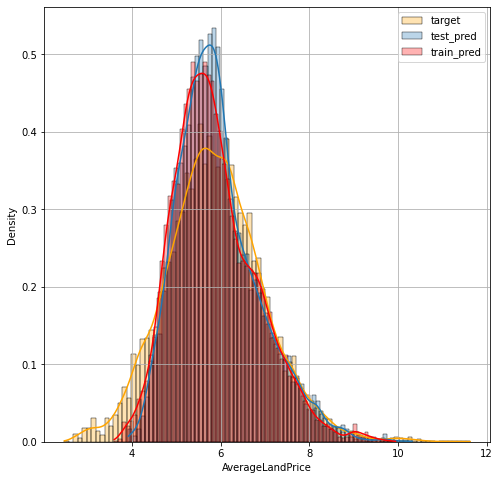

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(y, label='target', kde=True ,stat="density", common_norm=False, color='orange', alpha=0.3)
sns.histplot(test_preds_stack, label='test_pred', kde=True, stat="density", common_norm=False, alpha=0.3)
sns.histplot(oof_preds_stack, label='train_pred', kde=True, stat="density", common_norm=False, alpha=0.3,color='r')
ax.legend()
ax.grid()

AttributeError: ignored

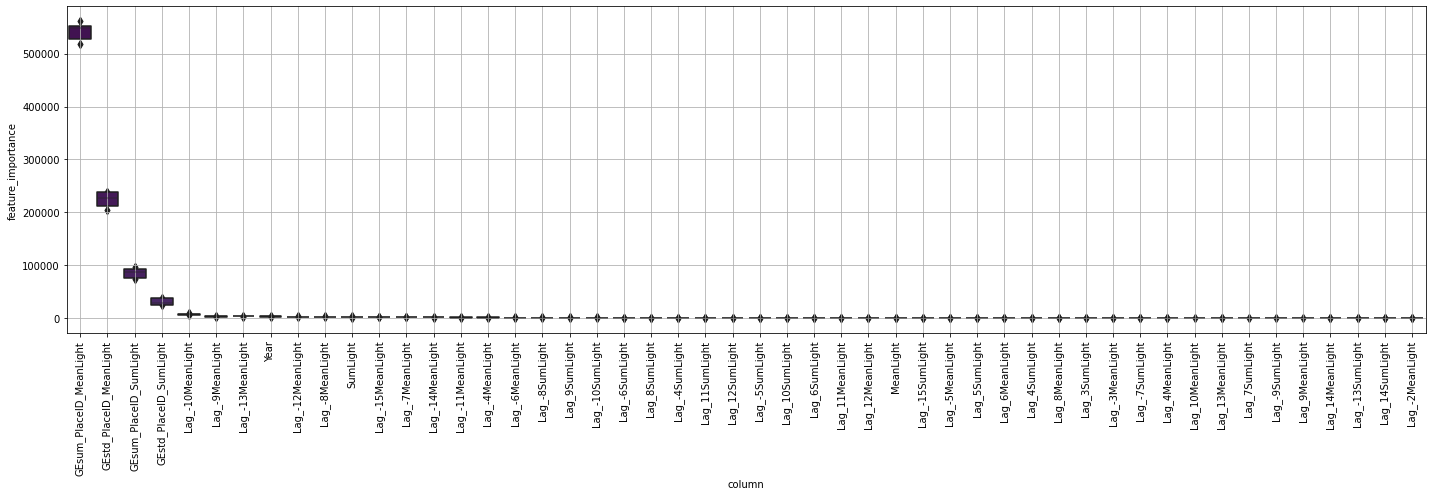

In [50]:
model2.visualize_importance

In [51]:
y_sub = np.expm1(test_pred_stack)
#sub_data = pd.read_csv(os.path.join(OUTPUT_DIR, NB_NAME)), )
sub_df = pd.read_csv(os.path.join(INPUT_DIR, 'UploadFileTemplate.csv'))
sub_df['LandPrice'] = y_sub

sub_df.to_csv(os.path.join(OUTPUT_DIR, 'sub_' + NB_NAME +'.csv'), index=False)